1.Importing Required Libraries and Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
import joblib

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.Data Preprocessing and Feature Engineering for Time-Series Analysis

In [2]:
def load_and_preprocess(filepath):
    """Load data and handle missing values with time-aware processing"""
    df = pd.read_csv(filepath)
    
    # Convert and sort dates
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
    df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
    
    # Time-aware imputation
    df = df.set_index("Date")
    df = df.interpolate(method='time').ffill().bfill()
    df = df.reset_index()
    
    # Feature Engineering (fixed shift order)
    df["DayOfYear"] = df["Date"].dt.dayofyear
    for i in range(1, 4):
        df[f"MinTemp_Lag{i}"] = df["MinTemp"].shift(i)
        df[f"MaxTemp_Lag{i}"] = df["MaxTemp"].shift(i)
        df[f"Rainfall_Lag{i}"] = df["Rainfall"].shift(i)
    
    # Rolling means with strict backward-looking window
    df["MinTemp_7DayMean"] = df["MinTemp"].shift(1).rolling(7).mean()
    df["MaxTemp_7DayMean"] = df["MaxTemp"].shift(1).rolling(7).mean()
    
    # Temporal features
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["Month"] = df["Date"].dt.month
    
    # Drop initial rows with NaN from lag/rolling features
    return df.dropna()

3.Data Visualization and Exploration of Weather Variables

C:\Users\DELL\AppData\Local\Temp\ipykernel_29240\3036736133.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Month', y='MaxTemp', palette='coolwarm')


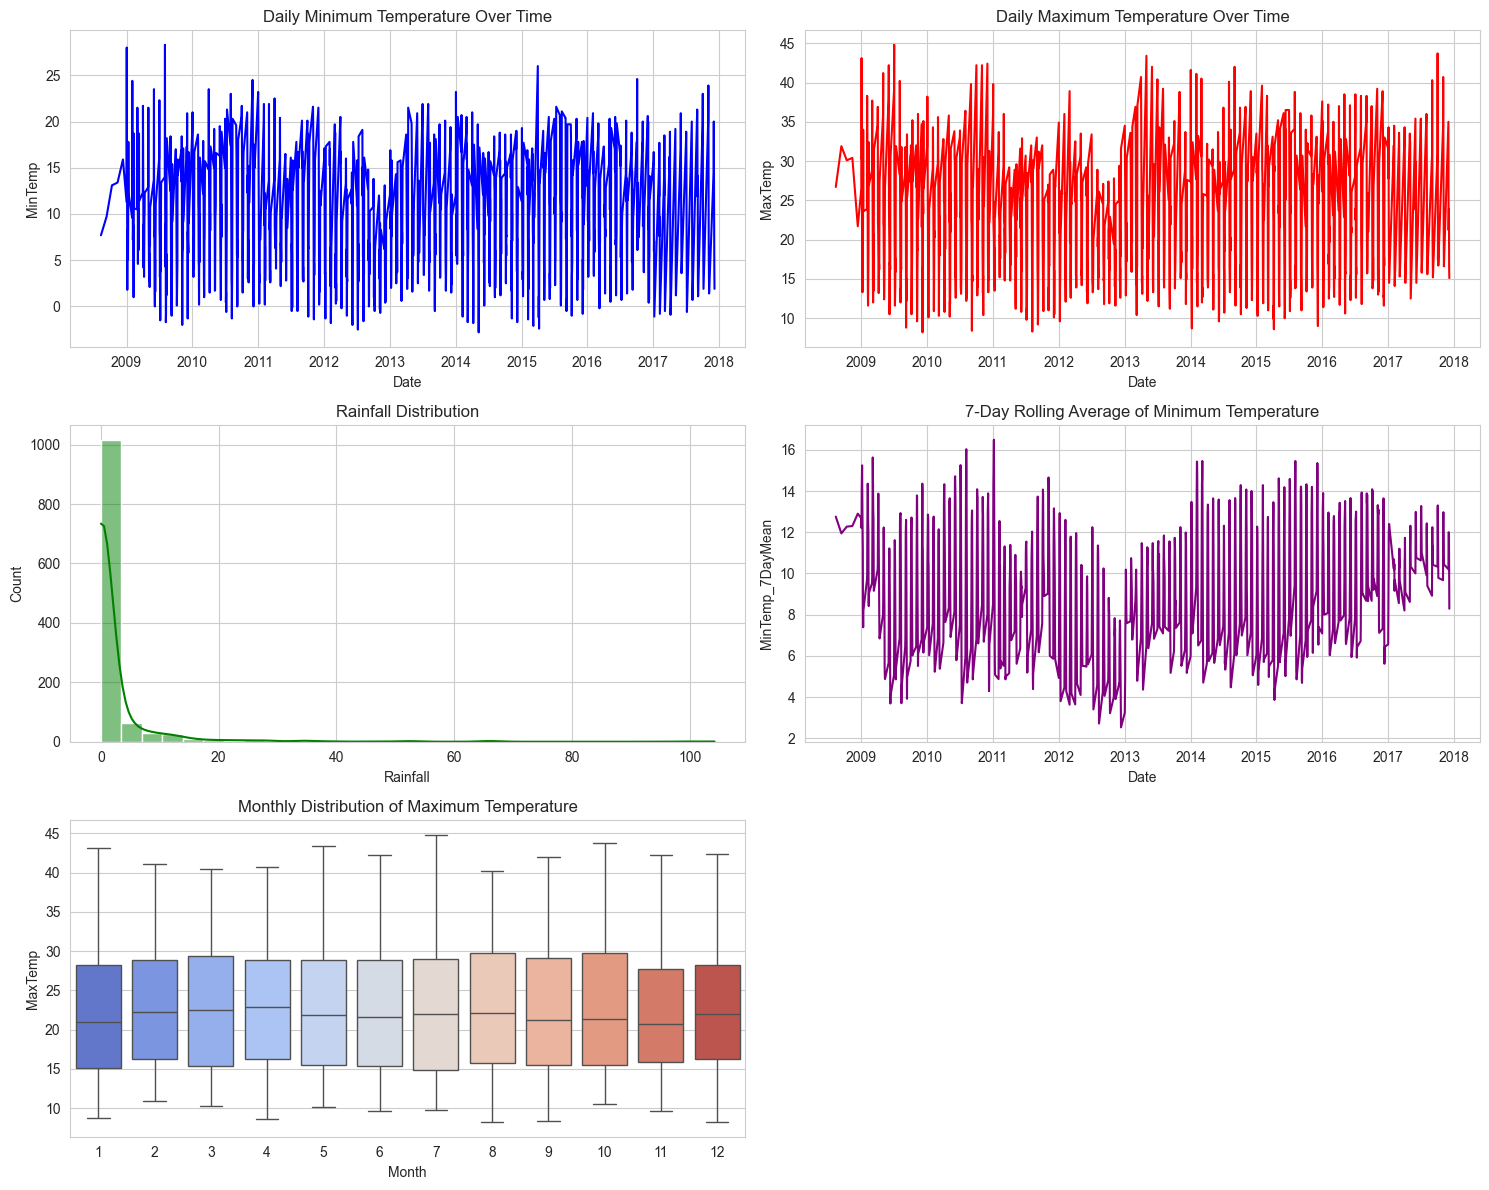

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
df = load_and_preprocess(r'C:\Master DSEF\Semester3\Deep_learning\DL_final_project\TemperatureRainFall.csv')

# Set up visualizations
plt.figure(figsize=(15, 12))
sns.set_style("whitegrid")

# 1. MinTemp Time Series
plt.subplot(3, 2, 1)
sns.lineplot(data=df, x='Date', y='MinTemp', color='blue')
plt.title('Daily Minimum Temperature Over Time')

# 2. MaxTemp Time Series
plt.subplot(3, 2, 2)
sns.lineplot(data=df, x='Date', y='MaxTemp', color='red')
plt.title('Daily Maximum Temperature Over Time')

# 3. Rainfall Distribution
plt.subplot(3, 2, 3)
sns.histplot(df['Rainfall'], bins=30, kde=True, color='green')
plt.title('Rainfall Distribution')

# 4. 7-Day Rolling Average (MinTemp)
plt.subplot(3, 2, 4)
sns.lineplot(data=df, x='Date', y='MinTemp_7DayMean', color='purple')
plt.title('7-Day Rolling Average of Minimum Temperature')

# 5. Temperature Variation by Month
plt.subplot(3, 2, 5)
sns.boxplot(data=df, x='Month', y='MaxTemp', palette='coolwarm')
plt.title('Monthly Distribution of Maximum Temperature')

plt.tight_layout()
plt.show()

4.Splitting Data into Training and Testing Sets

In [9]:
# Time-based split 
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [4]:
# Prepare Features (X) and Targets (y)
# --------------------------
# Drop Date and target columns to create features (X)
X = df.drop([
    'Date',
    'MinTemp',   # Target 1
    'MaxTemp',   # Target 2
    '9amTemp',   # Target 3
    '3pmTemp',   # Target 4
    'Rainfall'   # Target 5
], axis=1)

# Define targets 
y = df[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp', 'Rainfall']]

5.Model Training and Evaluation

In [5]:
# Model Training
# --------------------------
from sklearn.model_selection import TimeSeriesSplit

def train_model(X_train, y_train):
    """Improved training with early stopping"""
    model = MultiOutputRegressor(
        GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=5,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=42
        )
    )
    model.fit(X_train, y_train)
    return model

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [6]:
# Evaluation
# --------------------------
def evaluate_model(model, X_test, y_test, targets):
    """Calculate MAE/RMSE for all targets"""
    y_pred = model.predict(X_test)
    results = {}
    for i, target in enumerate(targets):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
        results[target] = {"MAE": round(mae, 2), "RMSE": round(rmse, 2)}
    return pd.DataFrame(results)

6.Model Optimization and Hybrid Approach

In [7]:
# Hyperparameter Tuning (Improvement 1)
# --------------------------
def optimize_hyperparameters(X_train, y_train, X_test, y_test, n_trials=30):
    """Optimize using Optuna"""
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10)
        }
        model = MultiOutputRegressor(GradientBoostingRegressor(**params))
        model.fit(X_train, y_train)
        return mean_absolute_error(y_test, model.predict(X_test))
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

In [8]:
# Hybrid Model (Improvement 2)
# --------------------------
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, r2_score, roc_auc_score

class HybridWeatherModel:
    """Separate models for temperature and rainfall"""
    def __init__(self):
        self.temp_model = MultiOutputRegressor(
            GradientBoostingRegressor(n_estimators=200)
        )
        self.rain_model = GradientBoostingClassifier(n_estimators=150)  # Changed to Classifier
        
    def fit(self, X, y):
        # Train temperature model on all targets
        self.temp_model.fit(X, y[["MinTemp", "MaxTemp", "9amTemp", "3pmTemp"]])
        
        # Train rainfall classifier (predict if rain > 0)
        y_rain = (y["Rainfall"] > 0).astype(int)
        self.rain_model.fit(X, y_rain)
        
    def predict(self, X):
        # Predict temperatures
        temp_pred = self.temp_model.predict(X)
        
        # Predict rainfall probabilities
        rain_prob = self.rain_model.predict_proba(X)[:, 1]  # Probability of rain
        return np.hstack([temp_pred, rain_prob.reshape(-1, 1)])
    
    def evaluate(self, X, y_true):
        """Comprehensive evaluation for both components"""
        # Temperature metrics
        temp_pred = self.temp_model.predict(X)
        temp_metrics = {
            'MinTemp_MAE': mean_absolute_error(y_true['MinTemp'], temp_pred[:, 0]),
            'MaxTemp_MAE': mean_absolute_error(y_true['MaxTemp'], temp_pred[:, 1]),
            '9amTemp_MAE': mean_absolute_error(y_true['9amTemp'], temp_pred[:, 2]),
            '3pmTemp_MAE': mean_absolute_error(y_true['3pmTemp'], temp_pred[:, 3]),
        }
        
        # Rainfall metrics
        rain_prob = self.rain_model.predict_proba(X)[:, 1]
        rain_pred = (rain_prob > 0.5).astype(int)
        rain_metrics = {
            'Rainfall_Accuracy': accuracy_score((y_true['Rainfall'] > 0), rain_pred),
            'Rainfall_F1': f1_score((y_true['Rainfall'] > 0), rain_pred),
            'Rainfall_AUC': roc_auc_score((y_true['Rainfall'] > 0), rain_prob)
        }
        
        return {**temp_metrics, **rain_metrics}
    
   
# --------------------------
# Main Workflow
# --------------------------
if __name__ == "__main__":
    # Load and preprocess data
    df = load_and_preprocess(r'C:\Master DSEF\Semester3\Deep_learning\DL_final_project\TemperatureRainFall.csv')
    
    # Define features/targets
    features = [# Lag features (3 variables × 3 lags)
    'MinTemp_Lag1', 'MinTemp_Lag2', 'MinTemp_Lag3',
    'MaxTemp_Lag1', 'MaxTemp_Lag2', 'MaxTemp_Lag3',
    'Rainfall_Lag1', 'Rainfall_Lag2', 'Rainfall_Lag3',
    
    # Rolling means
    'MinTemp_7DayMean', 'MaxTemp_7DayMean',
    
    # Temporal features
    'DayOfWeek', 'Month', 'DayOfYear']
    targets = ["MinTemp", "MaxTemp", "9amTemp", "3pmTemp", "Rainfall"]
    
    # Split data
    train_size = int(len(df) * 0.8)
    X_train, X_test = df[features][:train_size], df[features][train_size:]
    y_train, y_test = df[targets][:train_size], df[targets][train_size:]
    
    # Base Model
    base_model = train_model(X_train, y_train)
    print("Base Model Performance:")
    print(evaluate_model(base_model, X_test, y_test, targets))
    
    # Improvement 1: Tuned Model
    best_params = optimize_hyperparameters(X_train, y_train, X_test, y_test)
    tuned_model = MultiOutputRegressor(GradientBoostingRegressor(**best_params))
    tuned_model.fit(X_train, y_train)
    print("\nTuned Model Performance:")
    print(evaluate_model(tuned_model, X_test, y_test, targets))
    
    # Improvement 2: Hybrid Model
    hybrid_model = HybridWeatherModel()
    hybrid_model.fit(X_train, y_train)
    print("\nHybrid Model Performance :")
    hybrid_metrics = hybrid_model.evaluate(X_test, y_test)
    print(pd.Series(hybrid_metrics).to_frame().T)
    
    # Save model for deployment
    joblib.dump(tuned_model, "weather_predictor.pkl")   
    

[I 2025-01-24 17:13:47,362] A new study created in memory with name: no-name-15b5b55e-b8d8-4116-9b53-fb12a7854946


Base Model Performance:
      MinTemp  MaxTemp  9amTemp  3pmTemp  Rainfall
MAE      3.90     4.33     3.55     4.30      3.49
RMSE     5.16     6.22     5.18     5.98      5.95


[I 2025-01-24 17:13:48,592] Trial 0 finished with value: 4.219784885025568 and parameters: {'n_estimators': 51, 'learning_rate': 0.19947285438523651, 'max_depth': 6}. Best is trial 0 with value: 4.219784885025568.
[I 2025-01-24 17:13:50,649] Trial 1 finished with value: 4.193079424508878 and parameters: {'n_estimators': 127, 'learning_rate': 0.22538483456773029, 'max_depth': 4}. Best is trial 1 with value: 4.193079424508878.
[I 2025-01-24 17:13:58,629] Trial 2 finished with value: 4.248631323231418 and parameters: {'n_estimators': 194, 'learning_rate': 0.01143574372512797, 'max_depth': 10}. Best is trial 1 with value: 4.193079424508878.
[I 2025-01-24 17:14:00,996] Trial 3 finished with value: 4.243682199799051 and parameters: {'n_estimators': 120, 'learning_rate': 0.21719381163333526, 'max_depth': 5}. Best is trial 1 with value: 4.193079424508878.
[I 2025-01-24 17:14:02,910] Trial 4 finished with value: 4.3281084654266335 and parameters: {'n_estimators': 154, 'learning_rate': 0.2825293


Tuned Model Performance:
      MinTemp  MaxTemp  9amTemp  3pmTemp  Rainfall
MAE      3.86     4.33     3.51     4.36      3.34
RMSE     5.08     6.22     5.08     6.09      5.95

Hybrid Model Performance :
   MinTemp_MAE  MaxTemp_MAE  9amTemp_MAE  3pmTemp_MAE  Rainfall_Accuracy  \
0     4.071924     4.392183     3.818543     4.342193           0.621277   

   Rainfall_F1  Rainfall_AUC  
0     0.264463      0.582576  


7.LSTM-Based Model: Preprocessing, Training, and Evaluation

In [10]:
# ---- LSTM-Specific Preprocessing ----
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler


# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Reshape for LSTM: [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# ---- LSTM Model ----
model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(32, activation='relu'),
    Dense(5)  # 5 output nodes
])
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, 
                    validation_split=0.2, verbose=1)

# Save model for deployment
model.save("weather_predictor_lstm.h5")

# ---- LSTM Evaluation ----
# ---- LSTM Evaluation ---- 
lstm_pred = model.predict(X_test_lstm)


# Temperature Metrics
print("\nLSTM Temperature Metrics:")
print("MAE:", mean_absolute_error(y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], lstm_pred[:, :4]))
print("RMSE:", np.sqrt(mean_squared_error(y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], lstm_pred[:, :4])))

# Rainfall Classification Metrics
rain_actual = (y_test['Rainfall'] > 0).astype(int)  # Binary actual values
rain_pred = (lstm_pred[:, 4] > 0.5).astype(int)     # Threshold predictions at 0.5mm

print("\nLSTM Rainfall Metrics:")
print("Accuracy:", accuracy_score(rain_actual, rain_pred))
print("F1 Score:", f1_score(rain_actual, rain_pred))
print("AUC-ROC:", roc_auc_score(rain_actual, lstm_pred[:, 4]))

# R² Scores for Regression Targets
print("\nLSTM R² Scores:")
print("MinTemp R²:", r2_score(y_test['MinTemp'], lstm_pred[:, 0]))
print("MaxTemp R²:", r2_score(y_test['MaxTemp'], lstm_pred[:, 1]))
print("9amTemp R²:", r2_score(y_test['9amTemp'], lstm_pred[:, 2]))
print("3pmTemp R²:", r2_score(y_test['3pmTemp'], lstm_pred[:, 3]))

Epoch 1/50


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 306.1980 - val_loss: 314.0170
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 288.5429 - val_loss: 300.4313
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 264.3172 - val_loss: 271.0673
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 236.2545 - val_loss: 216.2386
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 183.9936 - val_loss: 139.9522
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 122.8201 - val_loss: 71.7710
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 67.9060 - val_loss: 40.7691
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.8357 - val_loss: 32.1233
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.7431 - val_loss: 29.4010
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 37.2541 - val_loss: 27.3047
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.1065 - val_loss: 25.4120
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

LSTM Temperature Metrics:
MAE: 4.487645626068115
RMSE: 6.42400716391196

LSTM Rainfall Metrics:
Accuracy: 0.34893617021276596
F1 Score: 0.5173501577287066
AUC-ROC: 0.40921409214092136

LSTM R² Scores:
MinTemp R²: 0.1266525727059541
MaxTemp R²: 0.21628467700755782
9amTemp R²: 0.18316742909951855
3pmTemp R²: 0.22723682162519032


8.Comparison of LSTM and Gradient Boosting Model Performance

In [11]:
# MAIN WORKFLOW WITH MODEL DEFINITIONS
# ====================================

# Define and train Gradient Boosting model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

gb_model = MultiOutputRegressor(
    GradientBoostingRegressor(n_estimators=200, max_depth=5)
)
gb_model.fit(X_train, y_train)  # Ensure X_train/y_train are defined


# Calculate metrics AFTER BOTH MODELS ARE TRAINED
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import numpy as np

# Gradient Boosting metrics
gb_pred = gb_model.predict(X_test)

# Temperature metrics (regression)
gb_temp_mae = mean_absolute_error(y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], gb_pred[:, :4])
gb_temp_rmse = np.sqrt(mean_squared_error(y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], gb_pred[:, :4]))

# Rainfall metrics (classification)
gb_rain_actual = (y_test['Rainfall'] > 0).astype(int)
gb_rain_pred = (gb_pred[:, 4] > 0.5).astype(int)  # Threshold at 0.5mm
gb_rain_acc = accuracy_score(gb_rain_actual, gb_rain_pred)

# LSTM metrics
lstm_pred = model.predict(X_test_lstm)

# Temperature metrics (regression)
lstm_temp_mae = mean_absolute_error(y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], lstm_pred[:, :4])
lstm_temp_rmse = np.sqrt(mean_squared_error(y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], lstm_pred[:, :4]))

# Rainfall metrics (classification)
lstm_rain_actual = (y_test['Rainfall'] > 0).astype(int)
lstm_rain_pred = (lstm_pred[:, 4] > 0.5).astype(int)  # Threshold at 0.5mm
lstm_rain_acc = accuracy_score(lstm_rain_actual, lstm_rain_pred)

# Create comparison table
results = pd.DataFrame({
    'Gradient Boosting': [gb_temp_mae, gb_temp_rmse, gb_rain_acc],
    'LSTM': [lstm_temp_mae, lstm_temp_rmse, lstm_rain_acc]
}, index=['Temperature MAE', 'Temperature RMSE', 'Rainfall Accuracy'])

print("Model Comparison:")
print(results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Comparison:
                   Gradient Boosting      LSTM
Temperature MAE             4.190679  4.487646
Temperature RMSE            5.801547  6.424007
Rainfall Accuracy           0.455319  0.348936


9.Visualization and Comparison of Gradient Boosting and LSTM Model Performance

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


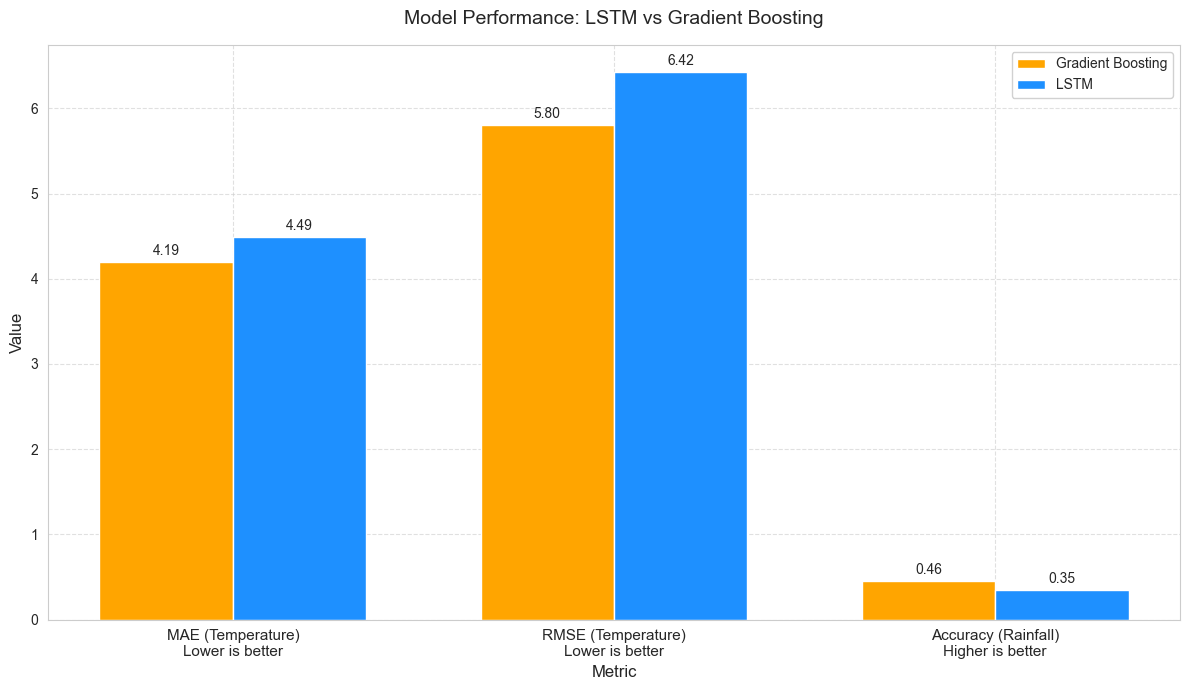

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

# -------------------------------------------------
# Gradient Boosting Metrics
# -------------------------------------------------
gb_pred = gb_model.predict(X_test)

# Temperature metrics (regression)
gb_mae = mean_absolute_error(
    y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], 
    gb_pred[:, :4]
)
gb_rmse = np.sqrt(
    mean_squared_error(
        y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], 
        gb_pred[:, :4]
    )
)

# Rainfall accuracy (classification)
gb_rain_actual = (y_test['Rainfall'] > 0).astype(int)
gb_rain_pred = (gb_pred[:, 4] > 0.5).astype(int)  # Threshold at 0.5mm
gb_acc = accuracy_score(gb_rain_actual, gb_rain_pred)

# -------------------------------------------------
# LSTM Metrics
# -------------------------------------------------
# Generate LSTM predictions (ensure X_test_lstm is properly reshaped)
lstm_pred = model.predict(X_test_lstm)

# Temperature metrics (regression)
lstm_mae = mean_absolute_error(
    y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], 
    lstm_pred[:, :4]
)
lstm_rmse = np.sqrt(
    mean_squared_error(
        y_test[['MinTemp', 'MaxTemp', '9amTemp', '3pmTemp']], 
        lstm_pred[:, :4]
    )
)

# Rainfall accuracy (classification)
lstm_rain_actual = (y_test['Rainfall'] > 0).astype(int)
lstm_rain_pred = (lstm_pred[:, 4] > 0.5).astype(int)  # Threshold at 0.5mm
lstm_acc = accuracy_score(lstm_rain_actual, lstm_rain_pred)
metrics = {
    'Gradient Boosting': {
        'MAE': gb_mae,
        'RMSE': gb_rmse,
        'Accuracy': gb_acc
    },
    'LSTM': {
        'MAE': lstm_mae,
        'RMSE': lstm_rmse,
        'Accuracy': lstm_acc
    }
}
import matplotlib.pyplot as plt
import numpy as np

# Set up plot
fig, ax = plt.subplots(figsize=(12, 7))

# Custom colors and bar properties
colors = {'Gradient Boosting': '#FFA500', 'LSTM': '#1E90FF'}
bar_width = 0.35
index = np.arange(3)  # For MAE, RMSE, Accuracy

# Plot bars
for i, (model_name, model_metrics) in enumerate(metrics.items()):
    positions = index + (i * bar_width) - bar_width/2
    ax.bar(
        positions,
        [model_metrics['MAE'], model_metrics['RMSE'], model_metrics['Accuracy']],
        bar_width,
        label=model_name,
        color=colors[model_name]
    )

# Formatting
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Model Performance: LSTM vs Gradient Boosting', fontsize=14, pad=15)
ax.set_xticks(index)
ax.set_xticklabels([
    'MAE (Temperature)\nLower is better',
    'RMSE (Temperature)\nLower is better',
    'Accuracy (Rainfall)\nHigher is better'
], fontsize=11)
ax.legend(framealpha=0.9)
ax.grid(True, linestyle='--', alpha=0.6)

# Add value labels
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()